#Diagram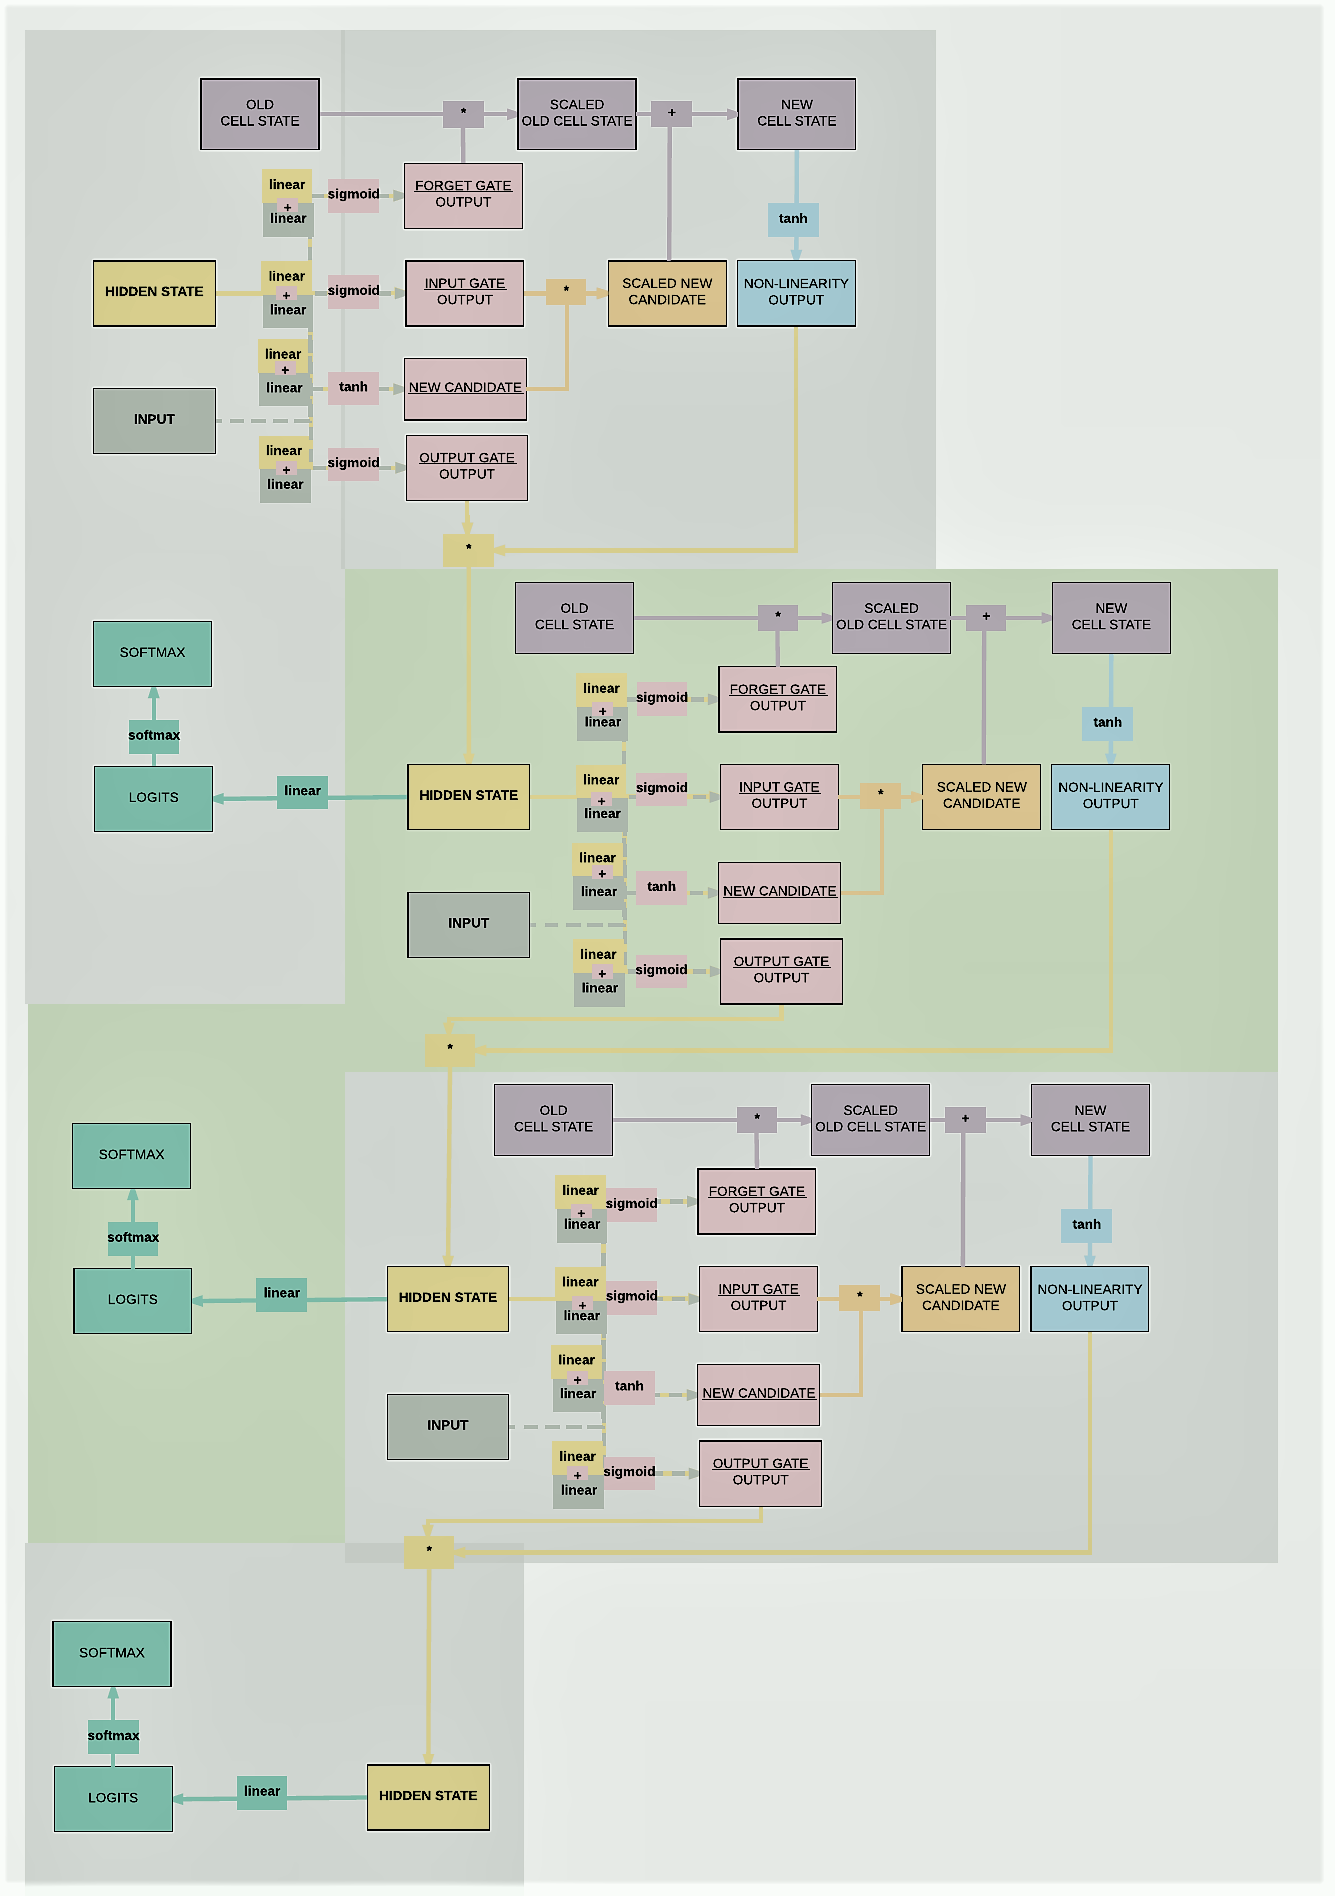

#Relative Performance

The attached LSTM implementation was significantly less effective than the CNN counterpart. This LSTM was not run to equivalent accuracy as the CNN due to time limitations.

#Regarding Joint RNNCNN Framework

The environmental motivation for a joint CNN-RNN framework is that virtually all real-world image data consists of multiple labels. Classification schemas that use purely CNNs typically accommodate this reality through independently handling each label, but this discards valuable inferential information that can be used to more quickly and accurately classify further labels to the image, e.g., “airplane” labels can lead the model to focus attention on looking for labels such as “sky” and “runway”. Using a joint CNN-RNN framework allows for a combination of strengths from both schemas, namely the joint image/label embedding and label co-occurrence models, and the result is a better focusing of computational resources as well as significantly higher classification accuracy.

In [ ]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [ ]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

In [ ]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
from torch.autograd import Variable

num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.4512050747871399, Accuracy: 87.80999755859375%
Iteration: 1000, Loss: 0.36635467410087585, Accuracy: 87.7699966430664%
Iteration: 1500, Loss: 0.29856565594673157, Accuracy: 88.73999786376953%
Iteration: 2000, Loss: 0.2522396743297577, Accuracy: 88.72000122070312%
Iteration: 2500, Loss: 0.17551559209823608, Accuracy: 89.44999694824219%
Iteration: 3000, Loss: 0.16279663145542145, Accuracy: 90.3499984741211%


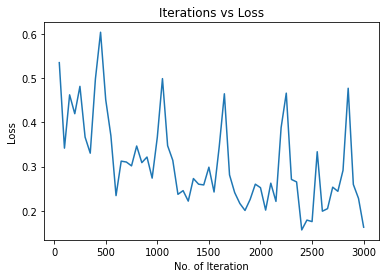

In [ ]:
import matplotlib.pyplot as plt
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

LSTMModel(
  (lstm): LSTM(28, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
# Number of steps to unroll
seq_dim = 28  

# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as a torch tensor with gradient accumulation abilities
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        outputs = outputs.to(device)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                # Resize images
                images = images.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(images)
                outputs = outputs.to(device)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            loss_list.append(loss.data)
            iteration_list.append(iter)
            accuracy_list.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.36026832461357117. Accuracy: 88.38999938964844
Iteration: 1000. Loss: 0.2460172474384308. Accuracy: 87.86000061035156
Iteration: 1500. Loss: 0.19537168741226196. Accuracy: 87.90999603271484
Iteration: 2000. Loss: 0.33897045254707336. Accuracy: 87.81999969482422
Iteration: 2500. Loss: 0.18613901734352112. Accuracy: 87.3499984741211
Iteration: 3000. Loss: 0.16017745435237885. Accuracy: 88.05999755859375


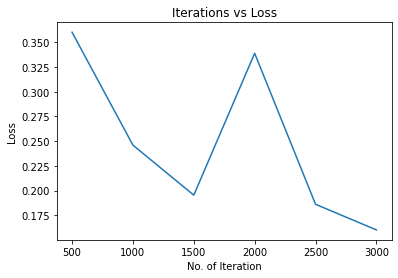

In [ ]:
import matplotlib.pyplot as plt
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()